# Project 1: Final Project
## Handwriting generating with RNN


<p class="lead">
<a href="https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info">Creative Applications of Deep Learning with Google's Tensorflow</a><br />
<a href="http://pkmital.com">Parag K. Mital</a> / <a href="https://twitter.com/rndbrtrnd">Arnaud Bertrand</a><br />
<a href="https://www.kadenze.com">Kadenze, Inc.</a>
</p>

# Table of Contents

- [Overview](#overview)
- [Fetching the network](#fetching-network)
  - [Import from the checkpoint](#import-from-chekpoint)
  - [Network structure](#net-structure) 
  - [Generating some samples](#generating-samples)
- [From static to motion](#from-static-to-motion) 

<a name="overview"></a>
# Overview

Few guidance is given for the project, especially compared to the sessions. This is good, since it pushes me to develop my creative skills. It could also be overwhelming, so I have decided to take few working assumptions.

The main one is to use a pre-designed net, and ideally even a pre-trained one, and to work around it. Designing an advanced NN requires a lot of effort, training it involves a lot of computing power (not mentioning the iterations). On the contrary, importing a net with the trained parameters is super easy. It has been done several times in the course, like with the Google inception v5 to generate deep dream pictures. Another assumption is to use a RNN. This architecture is incredibly powerful and has a high potential for generative art.

Before joining the course, I have been following the generative artist [Anders Hoff](https://twitter.com/inconvergent) for a couple of months, and I remember to have been amazed by the [Sand Glyphs](http://inconvergent.net/generative/sand-glyphs/) and the powerful effect of this asemic writing. Note that this algorithm is not based on neural nets. Then I have discovered [Hardmaru](https://twitter.com/hardmaru) by the impressive [large images generation from latent vectors](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/). It happens that Hardmaru has implemented with TensorFlow a random handwriting generation based on the Alex Graves' [paper](http://arxiv.org/abs/1308.0850). Handwriting is highly personal, expressive and unique, so having an algorithm generating its own style is just AWESOME. It looks like a perfect playground for exploration.

The implementation of  Hardmaru is available on [GitHub](https://github.com/hardmaru/write-rnn-tensorflow). It was based on Python 2 and TensorFlow r0.5. The first step has been to upgrade to Python 3 and TensorFlow r0.11. Hardmaru has been nice enough to merge my push requests into the main repository. The network had to be trained again, but since there is no change of design, and I knew that the training would last a couple of hours on a CPU, it was OK.

**Note:** the content of this repository heavily relies on the Hardmaru' implementation of the random handwriting generation.

In [1]:
# Let's improt the usual tools
import tensorflow as tf
import subprocess
import sys
import os
import pickle

%matplotlib inline

In [2]:
# Bit of formatting because I have good taste too:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="fetching-network"></a>
# Fetching the network

<a name="import-from-chekpoint"></a>
## Import from the checkpoint

As a prerequisite, clone locally ``write-rnn-tensorflow`` and update the static variable ``WRITE_RNN_DIR`` to the location of your clone. We will then import a module containing the network and some utils functions.

In [3]:
WRITE_RNN_DIR = '../../write-rnn-tensorflow'
sys.path.append(WRITE_RNN_DIR)

from model import Model
from utils import *

If everything runs fine, you can now import the neural net.

In [4]:
# Initiate TF
with open(os.path.join(WRITE_RNN_DIR, 'save', 'config.pkl'), 'rb') as f:
    saved_args = pickle.load(f)
tf.reset_default_graph()
model = Model(saved_args, True)
sess = tf.InteractiveSession()
saver = tf.train.Saver()

# Load the model
ckpt = tf.train.get_checkpoint_state(os.path.join(WRITE_RNN_DIR, 'save'))
saver.restore(sess, ckpt.model_checkpoint_path)

print("model loaded from: ", ckpt.model_checkpoint_path)
print("saved parameters: ", saved_args)

model loaded from:  ../../write-rnn-tensorflow/save/model.ckpt-11000
saved parameters:  Namespace(batch_size=1, data_scale=20, decay_rate=0.95, grad_clip=10.0, keep_prob=0.8, learning_rate=0.005, model='lstm', num_epochs=30, num_layers=2, num_mixture=20, rnn_size=256, save_every=500, seq_length=1)


<a name="net-structure"></a>
## Network structure

Let's have a look at the graph. As you can see, the architecture is a RNN based on LSTM cells. This network is reasonably complex. You can refer to the original blog post, [Handwriting Generation Demo in TensorFlow]() http://blog.otoro.net/2015/12/12/handwriting-generation-demo-in-tensorflow/) for all the details and rationals. To speak the truth, I didn't spend too much time on it. I would get back to it one day.

In [5]:
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
print(names)

['Placeholder', 'Placeholder_1', 'pack', 'zeros/Const', 'zeros', 'rnnlm/output_w', 'rnnlm/output_w/Initializer/random_uniform/shape', 'rnnlm/output_w/Initializer/random_uniform/min', 'rnnlm/output_w/Initializer/random_uniform/max', 'rnnlm/output_w/Initializer/random_uniform/RandomUniform', 'rnnlm/output_w/Initializer/random_uniform/sub', 'rnnlm/output_w/Initializer/random_uniform/mul', 'rnnlm/output_w/Initializer/random_uniform', 'rnnlm/output_w/Assign', 'rnnlm/output_w/read', 'rnnlm/output_b', 'rnnlm/output_b/Initializer/random_uniform/shape', 'rnnlm/output_b/Initializer/random_uniform/min', 'rnnlm/output_b/Initializer/random_uniform/max', 'rnnlm/output_b/Initializer/random_uniform/RandomUniform', 'rnnlm/output_b/Initializer/random_uniform/sub', 'rnnlm/output_b/Initializer/random_uniform/mul', 'rnnlm/output_b/Initializer/random_uniform', 'rnnlm/output_b/Assign', 'rnnlm/output_b/read', 'split/split_dim', 'split', 'Squeeze', 'rnnlm_1/MultiRNNCell/Cell0/Slice/begin', 'rnnlm_1/MultiRNNCel

<a name="generating-samples"></a>
## Generating some samples

There is a convenient method in the ``model`` object to generate a sample. The statement below will generate a sample of length ``SAMPLE_LENGTH``. I will explain just after the meaning of outputs ``strokes`` and ``params``.

In [6]:
SVG_SCALE_FACTOR = 10
SAMPLE_LENGTH = 800
SAMPLE_FILENAME = 'sample-write-rnn'

[strokes, params] = model.sample(sess, SAMPLE_LENGTH)

The model may be complex, but it is very easy to use. The ``strokes`` numpy array is a list of coordinates, with an additional parameter for each coordinates to indicate if it is the beginning of a new stroke. The coordinates describe a path which is the handwritten line. This is that simple. The ``params`` are the parameters of a micture 2d gaussian.

In [7]:
print(strokes[10:20])
print(params[40][3])

[[  19.29658318   -2.4791801     0.        ]
 [  20.59043503   -4.2667408     0.        ]
 [  18.07727814   -3.70807528    1.        ]
 [   1.31402159 -103.91460419    0.        ]
 [   3.982023     -3.15445709    0.        ]
 [   1.64404285   -3.96677923    0.        ]
 [  11.1435585    -1.23686886    0.        ]
 [  19.33837128    3.41951394    0.        ]
 [  20.36834526    1.05387962    0.        ]
 [  25.26060295    7.32383633    0.        ]]
[ 0.18158564  0.37723002  2.33718562  0.17126088  0.16212672  0.16308044
  0.43643698  1.00895095  0.27364537  0.76915479  0.13254602  0.68646318
  0.20894548  0.13102624  0.22123122  0.25034481  0.1451057   6.46011639
  0.14465795  0.17887118]


Hardmaru has built utils functions to display the ``strokes``. The first one renders simply the handwriting with a black color. The next one changes color at each new stroke, with a delightful effect. As you can see, the text is not intelligible, but it displays many artifacts of the latin handwriting, like the curls, letters with lower and upper parts and even sometimes words. I consider it as a [asemic writing](https://en.wikipedia.org/wiki/Asemic_writing), even if at the first look it could be consider as normal.

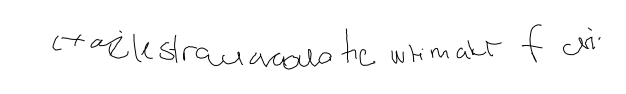

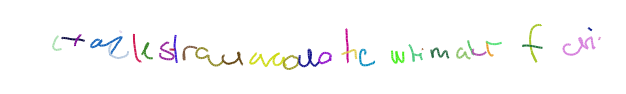

In [8]:
draw_strokes(strokes, factor=SVG_SCALE_FACTOR, svg_filename = SAMPLE_FILENAME+'.normal.svg')
draw_strokes_random_color(strokes, factor=SVG_SCALE_FACTOR, svg_filename = SAMPLE_FILENAME+'.color.svg')

Unfortunately there is no option to parametrize the output. You cannot input a string in this network like in the Alex Graves’ demo. Moreover, you may expect a kind of latent space here. Interesting thoughts for a next project.

<a name="from-static-to-motion"></a>
# From static to motion

In this part I will generate a gif to watch the network in action. Each frame will be a part of a step further in the overall path. I will also crop and move the center position along. I have created my own utils library to keep the code in the notebook more readable. 

In [9]:
from libs import utils, svg_utils

MARGIN = 25
GIF_STEP = 5
GIF_LENGTH = 800
GIF_FILENAME = 'rnn-write'
CONVERT_DENSITY = 400
TEMP_FILES = os.path.join('tmp', 'gif-frame-tmp')

if not os.path.exists('tmp'):
    os.mkdir('tmp')

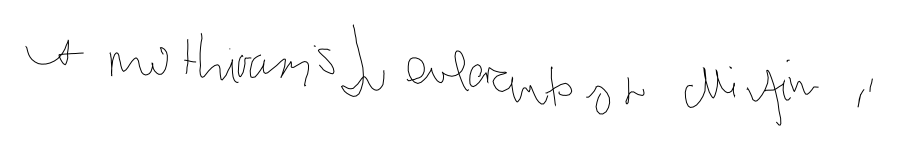

In [10]:
[strokes, params] = model.sample(sess, GIF_LENGTH)
draw_strokes(strokes, factor=SVG_SCALE_FACTOR, svg_filename = GIF_FILENAME+'.svg')

In [11]:
# Get size and frame
min_x, max_x, min_y, max_y = get_bounds(strokes, SVG_SCALE_FACTOR)
size_x = MARGIN * 2 + max_x - min_x
size_y = MARGIN * 2 + max_y - min_y
abs_x = MARGIN - min_x
abs_y = MARGIN - min_y
# Loop
imgs = []
for i in range(int(GIF_LENGTH * 4 / 100), len(strokes)):
    if (i % GIF_STEP) == 0:
        dwg = svg_utils.initiate(size_x, size_y, TEMP_FILES+'.svg')
        svg_utils.add_row_strokes(dwg, abs_x, abs_y, strokes[:i], SVG_SCALE_FACTOR)
        dwg.save()
        img = svg_utils.convert_to_img(TEMP_FILES+'.svg', TEMP_FILES+'.png', CONVERT_DENSITY)
        he, le, _ = img.shape
        pos = int((i / len(strokes)) * (le - he))
        print(i, le, he, pos)
        gif_frame = utils.img_crop(img, pos)
        imgs.append(gif_frame)

35 4994 833 182
40 4994 833 208
45 4994 833 234
50 4994 833 260
55 4994 833 286
60 4994 833 312
65 4994 833 338
70 4994 833 364
75 4994 833 390
80 4994 833 416
85 4994 833 442
90 4994 833 468
95 4994 833 494
100 4994 833 520
105 4994 833 546
110 4994 833 572
115 4994 833 598
120 4994 833 624
125 4994 833 650
130 4994 833 676
135 4994 833 702
140 4994 833 728
145 4994 833 754
150 4994 833 780
155 4994 833 806
160 4994 833 832
165 4994 833 858
170 4994 833 884
175 4994 833 910
180 4994 833 936
185 4994 833 962
190 4994 833 988


KeyboardInterrupt: 

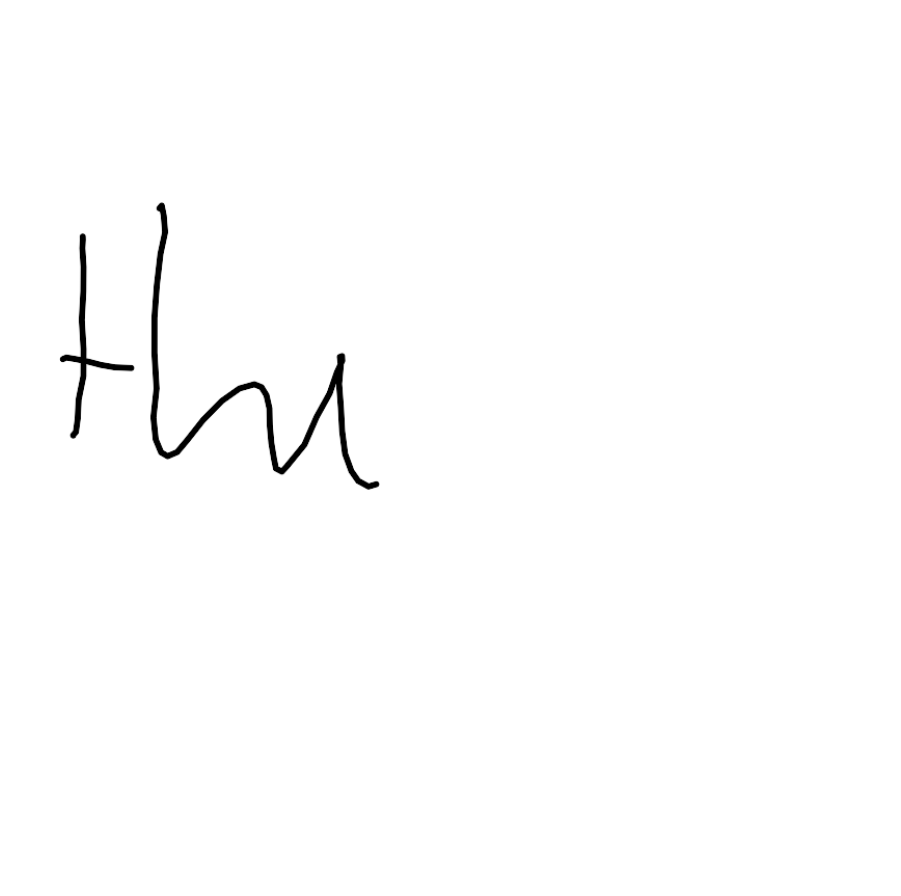

In [13]:
_ = utils.build_gif(imgs, interval=0.1, saveto=GIF_FILENAME+'.gif', show_gif=False)

# rnn-glyphs

In [ ]:
SIZE = 1400
MARGIN = 50
SPACING = 65

ROW_NUM = 20
SAMPLE_LENGTH = 1200

SVG_SCALE_FACTOR = 10
SVG_FILENAME = 'rnn-glyphs.svg'

In [ ]:
strokes_rows = []
for _ in range(ROW_NUM):
    [strokes, _] = model.sample(sess, SAMPLE_LENGTH)
    strokes_rows.append(strokes)

In [ ]:
draw_strokes(strokes_rows[0], factor=SVG_SCALE_FACTOR, svg_filename = 'test'+SVG_FILENAME)

In [ ]:
def add_row_strokes(row_num, data):
    
    min_x, max_x, min_y, max_y = get_bounds(data, SVG_SCALE_FACTOR)
    print(row_num, max_x, max_y)
     
    lift_pen = 1
    
    abs_x = MARGIN - min_x 
    abs_y = MARGIN + row_num * SPACING - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    
    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""    
        x = float(data[i,0])/SVG_SCALE_FACTOR
        y = float(data[i,1])/SVG_SCALE_FACTOR
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    
    the_color = "black"
    stroke_width = 1
    
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))

In [ ]:
dims = (SIZE, SIZE)
dwg = svgwrite.Drawing(SVG_FILENAME, size=dims)
dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))

In [ ]:
for tup in enumerate(strokes_rows):
    add_row_strokes(tup[0], tup[1])

In [ ]:
dwg.save()